In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import random
import struct
import subprocess
import sys
from matplotlib.patches import Rectangle

In [2]:
base_dir = os.getcwd()
exec_dir = '..'

In [3]:
# Returns all records whose location is in the given range.
def range_query(df, lx, ly, ux, uy):
    return (df[(df.x >= lx) & (df.x <= ux) & (df.y >= ly) & (df.y <= uy)])

# Returns the bounding rectangle of a Pandas dataframe.
def bounding_rect(df):
    return (np.min(df['x']), np.min(df['y']), np.max(df['x']), np.max(df['y']))

# Generates a random rectangle inside the given interval.
def random_rect(lx, ly, ux, uy):
    # Generate a random lower-left vertex.
    px = np.random.randint(lx, ux+1)
    py = np.random.randint(ly, uy+1)
    width = np.random.randint(0, ux-px+1)
    height = np.random.randint(0, uy-py+1)
    return (px, py, px+width, py+height)

def to_string(rect):
    return '({}, {}, {}, {})'.format(rect[0],rect[1],rect[2],rect[3])

def queries_with_fraction(df, fmin, fmax):
    return (df[(df.fraction >= fmin) & (df.fraction <= fmax)]).sort_values('fraction')

In [4]:
df = pd.read_csv('data/crash_data.csv')
df.head()

,ID,Year,Month,Day,Time,x,y
0,2012-1-27/05/2021,2012,January,Sunday,04:30 pm,133065971,167179587
1,2012-2-27/05/2021,2012,January,Sunday,09:10 am,132940015,166846266
2,2012-3-27/05/2021,2012,January,Wednesday,11:30 am,131374822,162424128
3,2012-4-27/05/2021,2012,January,Wednesday,10:20 am,132532677,167242555
4,2012-5-27/05/2021,2012,January,Wednesday,03:30 pm,132605645,167302842


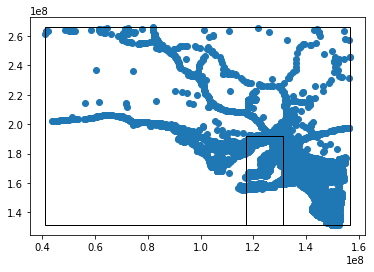

In [5]:
r = bounding_rect(df)
q = random_rect(r[0],r[1],r[2],r[3])
plt.scatter(df.x, df.y)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
plt.gca().add_patch(Rectangle((q[0], q[1]), q[2]-q[0], q[3]-q[1], fill=None, alpha=1))

# Query generation

We construct a data set of $10^6$ random queries on the data set with $m=30000$ points.

For each query, we measure the number of records that satisfy it.

This is done by means of our <code>QueryGenerator</code> C++ program.

In [6]:
m = 30000
data_file = 'data/crash_data_{}.csv'.format(m)
query_file = 'data/random_queries.csv'
n_queries = 1000000
params = ['../QueryGenerator', data_file, query_file, str(n_queries)]
p = subprocess.run(params, capture_output=True, check=True)
print('Done!')

Done!


Then we consider fractions from 10% to 90%. For each fraction we select 50 queries with that fraction and create separate data sets.

In [7]:
query_file = 'data/random_queries.csv'
query_df = pd.read_csv(query_file)
for i in range(1, 10):
    size = len(queries_with_fraction(query_df, i/10-0.01, i/10+0.01))
    print('Fraction: {}%\tQueries: {}'.format(i*10, size))

Fraction: 10%	Queries: 1772
Fraction: 20%	Queries: 699
Fraction: 30%	Queries: 497
Fraction: 40%	Queries: 394
Fraction: 50%	Queries: 318
Fraction: 60%	Queries: 410
Fraction: 70%	Queries: 558
Fraction: 80%	Queries: 939
Fraction: 90%	Queries: 8168


In [8]:
sampled_queries_per_fraction = 100
for i in range(1, 10):
    q_part = queries_with_fraction(query_df, i/10-0.01, i/10+0.01)
    q_part = q_part.sample(n=sampled_queries_per_fraction)
    q_part.to_csv('data/random_queries_{}.csv'.format(i*10), index=False)
print('Done!')

Done!


# Fraction of records (10%-90%)

In [16]:
m=30000
c=16
input_file = '{}/data/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_fraction.csv'.format(base_dir)

In [17]:
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    print('Testing fraction = {}%...'.format(i*10))
    query_file = '{}/data/random_queries_{}.csv'.format(base_dir, i*10)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i*10,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Testing fraction = 10%...
Testing fraction = 20%...
Testing fraction = 30%...
Testing fraction = 40%...
Testing fraction = 50%...
Testing fraction = 60%...
Testing fraction = 70%...
Testing fraction = 80%...
Testing fraction = 90%...
Done!


In [18]:
df=pd.read_csv('test_query_verification/test_fraction.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'fraction':str, 'avg_returned': int, 'avg_matching': int})
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
#df['noise'] = (df['avg_returned']-df['avg_matching'])/(df['avg_returned']-2*df['avg_matching']+30000)
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
      10 &         11673 &          3006 &  0.742 &      1.669 &      8.565 \\
      20 &         16003 &          5970 &  0.627 &      2.228 &     13.280 \\
      30 &         15659 &          8982 &  0.426 &      2.255 &     15.355 \\
      40 &         17092 &         12009 &  0.297 &      2.429 &     18.245 \\
      50 &         21049 &         15007 &  0.287 &      3.015 &     22.842 \\
      60 &         21740 &         18011 &  0.172 &      3.155 &     25.368 \\
      70 &         24143 &         21000 &  0.130 &      3.477 &     28.940 \\
      80 &         26441 &         23997 &  0.092 &      3.801 &     32.270 \\
      90 &         27853 &         27072 &  0.028 &      4.026 &     35.030 \\
\bottomrule
\end{tabular}



# Low fractions (1%-9%)

Let's see how many queries we can select for each fraction from 1% to 9%.

In [19]:
query_df = pd.read_csv('data/random_queries.csv')
for i in range(1, 10):
    size = len(queries_with_fraction(query_df, i/100-0.001, i/100+0.001))
    print('Fraction: {}%\tQueries: {}'.format(i, size))

Fraction: 1%	Queries: 15475
Fraction: 2%	Queries: 5689
Fraction: 3%	Queries: 4492
Fraction: 4%	Queries: 2735
Fraction: 5%	Queries: 1336
Fraction: 6%	Queries: 457
Fraction: 7%	Queries: 323
Fraction: 8%	Queries: 274
Fraction: 9%	Queries: 187


From these results, we see that we can select once again 100 queries for each fraction.

In [13]:
sampled_queries_per_fraction = 100
query_df = pd.read_csv('data/random_queries.csv')
for i in range(1, 10):
    q_part = queries_with_fraction(query_df, i/100-0.001, i/100+0.001)
    q_part = q_part.sample(n=sampled_queries_per_fraction)
    q_part.to_csv('data/random_queries_{}.csv'.format(i), index=False)
print('Done!')

Done!


Then we can run our simulation.

In [10]:
m=30000
c=16
input_file = '{}/data/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_fraction_low.csv'.format(base_dir)

In [13]:
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    print('Testing fraction = {}%...'.format(i))
    query_file = '{}/data/random_queries_{}.csv'.format(base_dir, i)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Testing fraction = 1%...
Testing fraction = 2%...
Testing fraction = 3%...
Testing fraction = 4%...
Testing fraction = 5%...
Testing fraction = 6%...
Testing fraction = 7%...
Testing fraction = 8%...
Testing fraction = 9%...
Done!


In [14]:
df=pd.read_csv('test_query_verification/test_fraction_low.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'fraction': str, 'avg_returned': int, 'avg_matching': int})
# Add % to fraction column.
df['fraction'] = df['fraction'] + '%'
# Compute noise.
#df['noise'] = (df['avg_returned']-df['avg_matching'])/(df['avg_returned']-2*df['avg_matching']+30000)
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
      1\% &          1902 &           299 &  0.843 &      0.231 &      1.264 \\
      2\% &          1979 &           598 &  0.698 &      0.279 &      1.676 \\
      3\% &          2519 &           897 &  0.644 &      0.354 &      2.154 \\
      4\% &          2648 &          1201 &  0.546 &      0.365 &      2.401 \\
      5\% &          3256 &          1499 &  0.540 &      0.459 &      2.993 \\
      6\% &          3943 &          1800 &  0.543 &      0.553 &      3.489 \\
      7\% &          4293 &          2101 &  0.511 &      0.603 &      3.928 \\
      8\% &          4467 &          2400 &  0.463 &      0.644 &      4.246 \\
      9\% &          5391 &          2699 &  0.499 &      0.782 &      4.909 \\
\bottomrule
\end{tabular}



# Capacity

Pick 500 queries with $f_Q \approx 20\%$. 
For each capacity value $c$ build a MR-tree on data set $\mathcal{D}$.
Then run Q and V on the 100 queries and compute an average.

In [31]:
n_queries = 500
fq = 0.2
q_part = queries_with_fraction(query_df, fq-0.01, fq+0.01)
q_part = q_part.sample(n=n_queries)
q_part.to_csv('data/random_queries_test_capacity.csv'.format(i*10), index=False)

In [32]:
n_records = 30000
query_file = 'test/data/random_queries_test_capacity.csv'
input_file = 'test/data/crash_data_{}.csv'.format(n_records)
output_file = 'test_query_verification/test_capacity.csv'
capacities = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

f = open(output_file, 'w')
f.write('capacity,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for c in capacities:
    # Run the C++ implementation.
    print('Testing capacity = {}...'.format(c))
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(c,avg_retur,avg_match,avg_query,avg_verif))

f.close()

os.chdir(base_dir)
print('Done!')

Testing capacity = 4...
Testing capacity = 8...
Testing capacity = 16...
Testing capacity = 32...
Testing capacity = 64...
Testing capacity = 128...
Testing capacity = 256...
Testing capacity = 512...
Testing capacity = 1024...
Testing capacity = 2048...
Done!


In [34]:
df=pd.read_csv('test_query_verification/test_capacity.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'avg_returned': int, 'avg_matching': int})
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Compute noise.
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
# Round the execution times to 3 decimal places.
df = df.round({'noise': 3, 'avg_query': 3, 'avg_verif': 3})
df = df[['capacity','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 capacity &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
        4 &         13835 &          5999 &  0.566 &      4.261 &     31.720 \\
        8 &         17754 &          5999 &  0.662 &      3.312 &     21.083 \\
       16 &         19532 &          5999 &  0.693 &      2.785 &     16.365 \\
       32 &         20325 &          5999 &  0.705 &      2.593 &     13.357 \\
       64 &         21204 &          5999 &  0.717 &      2.508 &     12.516 \\
      128 &         24077 &          5999 &  0.751 &      2.919 &     12.775 \\
      256 &         30000 &          5999 &  0.800 &      3.650 &     13.732 \\
      512 &         30000 &          5999 &  0.800 &      3.901 &     13.674 \\
     1024 &         30000 &          5999 &  0.800 &      3.782 &     13.615 \\
     2048 &         30000 &          5999 &  0.800 &      3.759 &     13.639 \\
\bottomrule
\end{tabular}



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


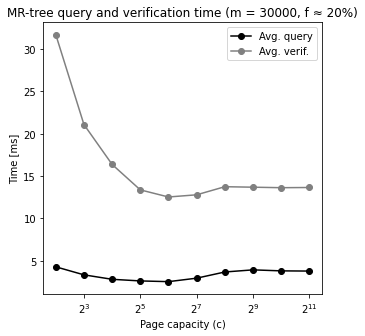

In [39]:
plt.figure(figsize=(5, 5))
plt.title("MR-tree query and verification time (m = 30000, f ≈ 20%)")
plt.xticks(df['capacity'])
plt.xscale('log', base=2)
plt.plot(df['capacity'], df['avg_query'], marker='o', color='black', label='Avg. query')
plt.plot(df['capacity'], df['avg_verif'], marker='o', color='grey', label='Avg. verif.')
#plt.axvline(75, 0, 1, color='gray', linestyle='--')
plt.ylabel("Time [ms]")
plt.xlabel("Page capacity (c)")
plt.legend()
plt.savefig("test_query_verification/test-capacity.eps", format='eps', bbox_inches='tight')

# Capacity (alternate test)

In [23]:
fq = 0.2
query_df = pd.read_csv('data/random_queries.csv')
q_part = queries_with_fraction(query_df, fq-0.01, fq+0.01)
q_part = q_part.sample(n=1)
q_part.to_csv('data/random_query_alt.csv', index=False)
q_part

,lx,ly,ux,uy,matching,fraction
374662,833900.0,1681160.0,1510620.0,1719180.0,5939,0.197967


In [26]:
n_records = 30000
n_trials = 20
query_file = 'test/data/random_query_alt.csv'
input_file = 'test/data/crash_data_{}.csv'.format(n_records)
output_file = 'test_query_verification/test_capacity_alt.csv'
capacities = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

f = open(output_file, 'w')
f.write('capacity,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for c in capacities:
    # Run the C++ implementation.
    print('Testing capacity = {}...'.format(c))
    params = ['./TestQuery', input_file, query_file, str(c)]
    avg_retur, avg_match, avg_query, avg_verif = 0, 0, 0, 0
    for i in range(0, n_trials):
        p = subprocess.run(params, capture_output=True, check=True)
        lines = p.stdout.decode('utf-8').splitlines()
        avg_retur += int((lines[1].split(':'))[1])
        avg_match += int((lines[2].split(':'))[1])
        avg_query += int((lines[3].split(':'))[1])
        avg_verif += int((lines[4].split(':'))[1])
    avg_retur /= n_trials
    avg_match /= n_trials
    avg_query /= n_trials
    avg_verif /= n_trials
    f.write('{},{},{},{},{}\n'.format(c,avg_retur,avg_match,avg_query,avg_verif))

f.close()

os.chdir(base_dir)
print('Done!')

Testing capacity = 4...
Testing capacity = 8...
Testing capacity = 16...
Testing capacity = 32...
Testing capacity = 64...
Testing capacity = 128...
Testing capacity = 256...
Testing capacity = 512...
Testing capacity = 1024...
Testing capacity = 2048...
Done!


In [27]:
df=pd.read_csv('test_query_verification/test_capacity_alt.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'avg_returned': int, 'avg_matching': int})
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Compute noise.
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
# Round the execution times to 3 decimal places.
df = df.round({'noise': 3, 'avg_query': 3, 'avg_verif': 3})
df = df[['capacity','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 capacity &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
        4 &         19744 &          5940 &  0.699 &      5.656 &     40.623 \\
        8 &         25920 &          5940 &  0.771 &      4.825 &     27.929 \\
       16 &         29184 &          5940 &  0.796 &      3.684 &     22.277 \\
       32 &         29696 &          5940 &  0.800 &      3.332 &     18.072 \\
       64 &         30000 &          5940 &  0.802 &      3.253 &     16.497 \\
      128 &         30000 &          5940 &  0.802 &      3.219 &     15.637 \\
      256 &         30000 &          5940 &  0.802 &      3.184 &     13.922 \\
      512 &         30000 &          5940 &  0.802 &      4.358 &     13.955 \\
     1024 &         30000 &          5940 &  0.802 &      4.113 &     13.965 \\
     2048 &         30000 &          5940 &  0.802 &      4.167 &     14.276 \\
\bottomrule
\end{tabular}



(41431860, 155741028, 132076965, 265135554)
(132076965, 160388738, 132431257, 217248865)
(132431285, 159729932, 132738629, 257675416)
(132738629, 160057448, 132951317, 215432389)
(132951393, 160251124, 133249300, 201904338)
(133249627, 160316054, 133687673, 192844012)
(133687673, 156383352, 140507324, 254292252)
(140512642, 131505047, 156208702, 263913783)


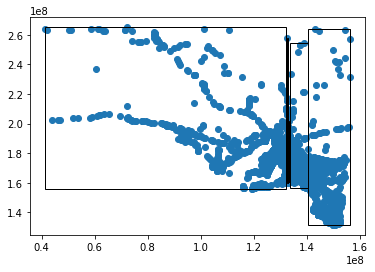

In [12]:
input_file = 'data/crash_data_30000.csv'
c = 16
params = ['../TestIndex', input_file, str(c)]
p = subprocess.run(params, capture_output=True, check=True)
df = pd.read_csv(input_file)
rects = pd.read_csv('rectangles.csv')
plt.scatter(df.x, df.y)
for index, row in rects.iterrows():
    r = (row.lx, row.ly, row.ux, row.uy)
    print(r)
    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

In [26]:
input_file = 'data/crash_data_30000.csv'
c = 16
params = ['../TestIndex', input_file, str(c)]
p = subprocess.run(params, capture_output=True, check=True)
df = pd.read_csv(input_file)
rects = pd.read_csv('rectangles.csv')

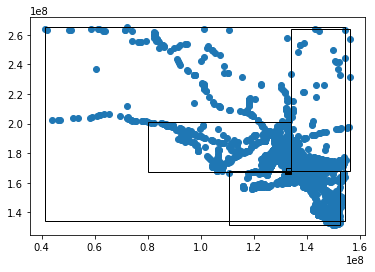

In [35]:
plt.scatter(df.x, df.y)
for index, row in rects.iterrows():
    r = (row.lx, row.ly, row.ux, row.uy)
    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


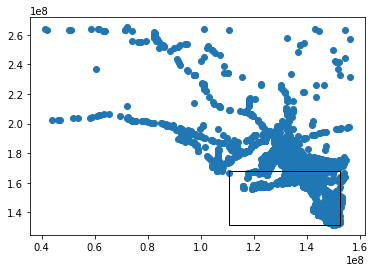

In [27]:
plt.scatter(df.x, df.y)
row = rects.loc[0]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


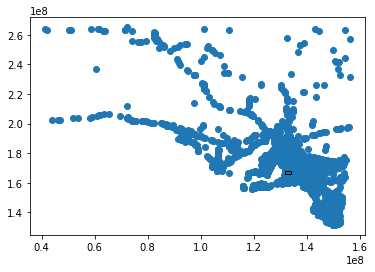

In [28]:
plt.scatter(df.x, df.y)
row = rects.loc[1]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


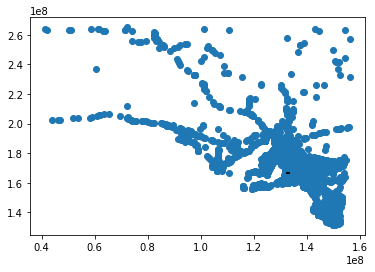

In [29]:
plt.scatter(df.x, df.y)
row = rects.loc[2]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


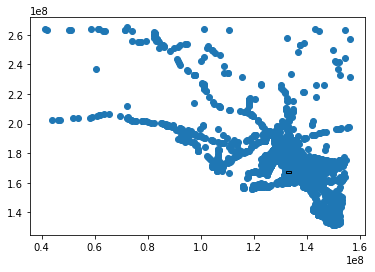

In [30]:
plt.scatter(df.x, df.y)
row = rects.loc[3]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


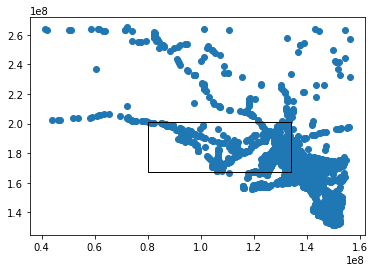

In [31]:
plt.scatter(df.x, df.y)
row = rects.loc[4]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


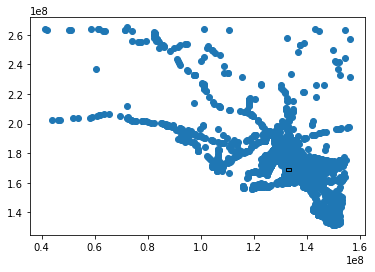

In [32]:
plt.scatter(df.x, df.y)
row = rects.loc[5]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


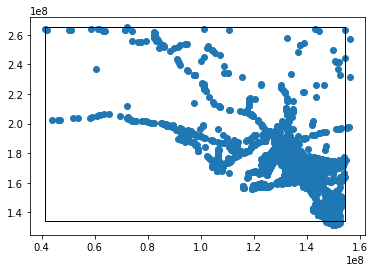

In [33]:
plt.scatter(df.x, df.y)
row = rects.loc[6]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

(110811200, 131505047, 152583837, 167697772)
(131787469, 165675048, 134217679, 167770926)
(132124387, 166725574, 133168963, 167509432)
(132123036, 166724530, 134209493, 167771985)
(80094037, 167251549, 134204155, 201180289)
(132296767, 167773410, 134208533, 169867695)
(41431860, 134217743, 154233575, 265135554)
(134219550, 167813254, 156208702, 263913783)


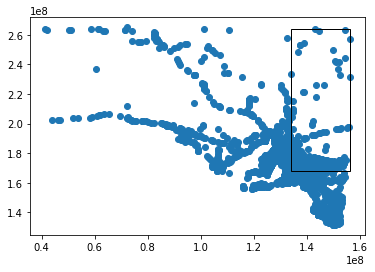

In [34]:
plt.scatter(df.x, df.y)
row = rects.loc[7]
r = (row.lx, row.ly, row.ux, row.uy)
for index, row in rects.iterrows():
    s = (row.lx, row.ly, row.ux, row.uy)
    print(s)
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
#    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))